# Computer Vision Nanodegree

## Project: Image Captioning

---

In this notebook, you will train your CNN-RNN model.  

You are welcome and encouraged to try out many different architectures and hyperparameters when searching for a good model.

This does have the potential to make the project quite messy!  Before submitting your project, make sure that you clean up:
- the code you write in this notebook.  The notebook should describe how to train a single CNN-RNN architecture, corresponding to your final choice of hyperparameters.  You should structure the notebook so that the reviewer can replicate your results by running the code in this notebook.  
- the output of the code cell in **Step 2**.  The output should show the output obtained when training the model from scratch.

This notebook **will be graded**.  

Feel free to use the links below to navigate the notebook:
- [Step 1](#step1): Training Setup
- [Step 2](#step2): Train your Model
- [Step 3](#step3): (Optional) Validate your Model

In [28]:
import nltk
import ssl
import os

# Create nltk_data directory if it doesn't exist
import os
nltk_data_dir = os.path.expanduser('~/nltk_data')
if not os.path.exists(nltk_data_dir):
    os.makedirs(nltk_data_dir)

# Disable SSL verification temporarily if needed
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

# Download required NLTK data
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)

# Verify the download
try:
    from nltk.tokenize import word_tokenize
    word_tokenize("Test sentence.")
    print("NLTK punkt is properly configured.")
except LookupError:
    print("Error: NLTK punkt is not properly configured.")
# Set NLTK data path explicitly
import os
nltk.data.path.append(os.path.expanduser('~/nltk_data'))

NameError: name 'ssl' is not defined

<a id='step1'></a>
## Step 1: Training Setup

In this step of the notebook, you will customize the training of your CNN-RNN model by specifying hyperparameters and setting other options that are important to the training procedure.  The values you set now will be used when training your model in **Step 2** below.

You should only amend blocks of code that are preceded by a `TODO` statement.  **Any code blocks that are not preceded by a `TODO` statement should not be modified**.

### Task #1

Begin by setting the following variables:
- `batch_size` - the batch size of each training batch.  It is the number of image-caption pairs used to amend the model weights in each training step. 
- `vocab_threshold` - the minimum word count threshold.  Note that a larger threshold will result in a smaller vocabulary, whereas a smaller threshold will include rarer words and result in a larger vocabulary.  
- `vocab_from_file` - a Boolean that decides whether to load the vocabulary from file. 
- `embed_size` - the dimensionality of the image and word embeddings.  
- `hidden_size` - the number of features in the hidden state of the RNN decoder.  
- `num_epochs` - the number of epochs to train the model.  We recommend that you set `num_epochs=3`, but feel free to increase or decrease this number as you wish.  [This paper](https://arxiv.org/pdf/1502.03044.pdf) trained a captioning model on a single state-of-the-art GPU for 3 days, but you'll soon see that you can get reasonable results in a matter of a few hours!  (_But of course, if you want your model to compete with current research, you will have to train for much longer._)
- `save_every` - determines how often to save the model weights.  We recommend that you set `save_every=1`, to save the model weights after each epoch.  This way, after the `i`th epoch, the encoder and decoder weights will be saved in the `models/` folder as `encoder-i.pkl` and `decoder-i.pkl`, respectively.
- `print_every` - determines how often to print the batch loss to the Jupyter notebook while training.  Note that you **will not** observe a monotonic decrease in the loss function while training - this is perfectly fine and completely expected!  You are encouraged to keep this at its default value of `100` to avoid clogging the notebook, but feel free to change it.
- `log_file` - the name of the text file containing - for every step - how the loss and perplexity evolved during training.

If you're not sure where to begin to set some of the values above, you can peruse [this paper](https://arxiv.org/pdf/1502.03044.pdf) and [this paper](https://arxiv.org/pdf/1411.4555.pdf) for useful guidance!  **To avoid spending too long on this notebook**, you are encouraged to consult these suggested research papers to obtain a strong initial guess for which hyperparameters are likely to work best.  Then, train a single model, and proceed to the next notebook (**3_Inference.ipynb**).  If you are unhappy with your performance, you can return to this notebook to tweak the hyperparameters (and/or the architecture in **model.py**) and re-train your model.

### Question 1

**Question:** Describe your CNN-RNN architecture in detail.  With this architecture in mind, how did you select the values of the variables in Task 1?  If you consulted a research paper detailing a successful implementation of an image captioning model, please provide the reference.

**Answer:**
Answer:

The CNN–RNN chain functions as an image captioning pipeline where the CNN encodes the image as a feature vector. In this case, the feature vector is 512-dimensional due to the ResNet-18 backbone. We obtain this vector by removing ResNet’s final classification layer and freezing its weights.

The RNN, implemented with an LSTM, is designed to work with sequence data, naturally handling a sentence as a sequence of words. For language generation, it can remember context over multiple words, modeling long-range dependencies.

[Image] → CNN → feature vector → LSTM → sequence of words

The CNN acts as a feature extractor for the image

The RNN acts as a language model conditioned on those features

Hyperparameters:

batch_size = 32
A practical choice balancing GPU memory and training speed. Large enough to stabilize gradient estimates, small enough for a single GPU.

vocab_threshold = 5
Filters out rare words that do not contribute to captioning performance. This is a common practice to keep the vocabulary size manageable and avoid overfitting on rare words.

vocab_from_file = True
Since a vocab.pkl is already generated, we reuse it to save preprocessing time.

embed_size = 256
Small enough for efficient training, while big enough to encode meaningful semantic information. Consistent with word embedding sizes (256–512) in NLP.

hidden_size = 512
Provides sufficient capacity to model rich language dependencies. Matches the scale of a moderately complex LSTM used in captioning literature.

num_epochs = 3
Selected for a first quick trial to verify convergence without long training times.

Reference:
Vinyals, Oriol, et al. Show and Tell: A Neural Image Caption Generator. CVPR 2015. arXiv:1411.4555



### (Optional) Task #2

Note that we have provided a recommended image transform `transform_train` for pre-processing the training images, but you are welcome (and encouraged!) to modify it as you wish.  When modifying this transform, keep in mind that:
- the images in the dataset have varying heights and widths, and 
- if using a pre-trained model, you must perform the corresponding appropriate normalization.

### Question 2

**Question:** How did you select the transform in `transform_train`?  If you left the transform at its provided value, why do you think that it is a good choice for your CNN architecture?

```
# ColorJitter can make the network more robust to color changes
# these do not harm training stability, but can help generalize.
 transform_train = transforms.Compose([
     transforms.Resize(256),
     transforms.RandomCrop(224),
     transforms.RandomHorizontalFlip(),                # random horizontal flip for data augmentation
     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # mild color jitter
     transforms.ToTensor(),
     transforms.Normalize((0.485, 0.456, 0.406),
                          (0.229, 0.224, 0.225)),
 ])

```

### Task #3

Next, you will specify a Python list containing the learnable parameters of the model.  For instance, if you decide to make all weights in the decoder trainable, but only want to train the weights in the embedding layer of the encoder, then you should set `params` to something like:
```
params = list(decoder.parameters()) + list(encoder.embed.parameters()) 
```

### Question 3
**Question:** How did you select the trainable parameters of your architecture?  Why do you think this is a good choice?

- We are using the pretrained ResNet-18 fixed
- The trainable parameters to include the final embedding layer after the CNN
- All layers of the RNN decoder.
- Freezing the main CNN saves training time and prevents overfitting
- The decoder fully is essential for language generation.

**Answer:** 

### Task #4
Finally, you will select an [optimizer](http://pytorch.org/docs/master/optim.html#torch.optim.Optimizer).

### Question 4
**Question:** How did you select the optimizer used to train your model?
**Answer:**
## Adam?
**Adam combines the benefits of RMSProp and momentum.**

* It adapts the learning rate per parameter, which is helpful in complex models with both CNN features and RNNs.
* The LSTM decoder benefits from Adam’s ability to handle sparse gradients, which are common in sequence models like language models.
* It requires less hyperparameter tuning compared to SGD or vanilla momentum optimizers — it just works well out of the box for this kind of task.
* In practice, most captioning papers (including *Show and Tell*) and popular codebases use Adam

**learning rate `1e-3`** is standard starting point for Adam.


In [24]:
import nltk
from numpy.ma.core import shape

nltk.download('punkt')

[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1007)>


False

In [25]:
import warnings
warnings.filterwarnings('ignore')

###############################

import torch
import torch.nn as nn
from torchvision import transforms
import sys
sys.path.append('external/cocoapi/PythonAPI')
from pycocotools.coco import COCO
from data_loader import get_loader
from model import EncoderCNN, DecoderRNN
import math


## TODO #1: Select appropriate values for the Python variables below.
batch_size = 32          # batch size
vocab_threshold =  5        # minimum word count threshold
vocab_from_file = True    # if True, load existing vocab file
embed_size = 256          # dimensionality of image and word embeddings
hidden_size = 512          # number of features in hidden state of the RNN decoder
num_epochs = 10             # number of training epochs
save_every = 1             # determines frequency of saving model weights
print_every = 100          # determines window for printing average loss
log_file = 'training_log.txt'       # name of file with saved training loss and perplexity

# (Optional) TODO #2: Amend the image transform below.
transform_train = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 128
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

# RandomHorizontalFlip() is standard for natural images and captions
# ColorJitter can make the network more robust to color changes
# these do not harm training stability, but can help generalize.
# transform_train = transforms.Compose([
#     transforms.Resize(256),
#     transforms.RandomCrop(224),
#     transforms.RandomHorizontalFlip(),                # random horizontal flip for data augmentation
#     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # mild color jitter
#     transforms.ToTensor(),
#     transforms.Normalize((0.485, 0.456, 0.406),
#                          (0.229, 0.224, 0.225)),
# ])

# Build data loader (TODO: You can change the subset_size, however a 
# very large value would increase training time considerably)
data_loader = get_loader(transform=transform_train,
                         mode='train',
                         batch_size=batch_size,
                         vocab_threshold=vocab_threshold,
                         vocab_from_file=vocab_from_file,
                         subset_size=20000,
                         cocoapi_loc='data')

# The size of the vocabulary.
vocab_size = len(data_loader.dataset.vocab)

# Initialize the encoder and decoder. 
encoder = EncoderCNN(embed_size)
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)

# Move models to GPU if CUDA is available. 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder.to(device)
decoder.to(device)

# Define the loss function. 
criterion = nn.CrossEntropyLoss().cuda() if torch.cuda.is_available() else nn.CrossEntropyLoss()

# TODO #3: Specify the learnable parameters of the model.
params = list(decoder.parameters()) + list(encoder.embed.parameters())


# TODO #4: Define the optimizer.
optimizer = torch.optim.Adam(params, lr=1e-3)

# Set the total number of training steps per epoch.
total_step = math.ceil(len(data_loader.dataset.caption_lengths) / data_loader.batch_sampler.batch_size)


Vocabulary successfully loaded from vocab.pkl file!
loading annotations into memory...
Done (t=0.20s)
creating index...
index created!
Obtaining caption lengths for the subset...


100%|██████████| 20000/20000 [00:00<00:00, 31562.63it/s]


In [26]:
import warnings
warnings.filterwarnings('ignore')

params = list(decoder.parameters()) + list(encoder.embed.parameters())
print ( params)




[Parameter containing:
tensor([[ 0.6640, -0.0364, -0.9377,  ..., -0.6515,  1.5529,  0.0288],
        [ 0.3593,  0.6709, -0.7416,  ...,  0.4730, -1.6485, -0.7794],
        [-0.1804,  0.4668, -0.4640,  ...,  0.1660,  0.7938, -0.5131],
        ...,
        [-0.2337,  0.2631, -1.2200,  ..., -0.6078, -0.1028, -0.8255],
        [-0.6749, -0.1913,  1.1161,  ...,  0.6585, -0.3188, -0.2102],
        [ 0.7107, -0.3221, -0.1883,  ...,  0.1698, -0.7884,  0.9341]],
       requires_grad=True), Parameter containing:
tensor([[-0.0419,  0.0258, -0.0311,  ...,  0.0016, -0.0385, -0.0056],
        [-0.0015, -0.0262, -0.0364,  ..., -0.0388,  0.0120,  0.0137],
        [ 0.0225,  0.0148,  0.0341,  ...,  0.0119,  0.0077,  0.0344],
        ...,
        [-0.0008,  0.0058,  0.0407,  ...,  0.0114, -0.0376, -0.0026],
        [ 0.0245, -0.0168, -0.0046,  ..., -0.0054,  0.0078, -0.0326],
        [-0.0021,  0.0299,  0.0138,  ...,  0.0382,  0.0242,  0.0402]],
       requires_grad=True), Parameter containing:
tensor([[

<a id='step2'></a>
## Step 2: Train your Model

Once you have executed the code cell in **Step 1**, the training procedure below should run without issue.  

It is completely fine to leave the code cell below as-is without modifications to train your model.  However, if you would like to modify the code used to train the model below, you must ensure that your changes are easily parsed by your reviewer.  In other words, make sure to provide appropriate comments to describe how your code works!  

You may find it useful to load saved weights to resume training.  In that case, note the names of the files containing the encoder and decoder weights that you'd like to load (`encoder_file` and `decoder_file`).  Then you can load the weights by using the lines below:

```python
# Load pre-trained weights before resuming training.
encoder.load_state_dict(torch.load(os.path.join('./models', encoder_file)))
decoder.load_state_dict(torch.load(os.path.join('./models', decoder_file)))
```

While trying out parameters, make sure to take extensive notes and record the settings that you used in your various training runs.  In particular, you don't want to encounter a situation where you've trained a model for several hours but can't remember what settings you used :).

### A Note on Tuning Hyperparameters

To figure out how well your model is doing, you can look at how the training loss and perplexity evolve during training - and for the purposes of this project, you are encouraged to amend the hyperparameters based on this information.  

However, this will not tell you if your model is overfitting to the training data, and, unfortunately, overfitting is a problem that is commonly encountered when training image captioning models.  

For this project, you need not worry about overfitting. **This project does not have strict requirements regarding the performance of your model**, and you just need to demonstrate that your model has learned **_something_** when you generate captions on the test data.  For now, we strongly encourage you to train your model for the suggested 3 epochs without worrying about performance; then, you should immediately transition to the next notebook in the sequence (**3_Inference.ipynb**) to see how your model performs on the test data.  If your model needs to be changed, you can come back to this notebook, amend hyperparameters (if necessary), and re-train the model.

That said, if you would like to go above and beyond in this project, you can read about some approaches to minimizing overfitting in section 4.3.1 of [this paper](http://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=7505636).  In the next (optional) step of this notebook, we provide some guidance for assessing the performance on the validation dataset.

Epoch [1/10], Step [100/625], Loss: 4.5100, Perplexity: 90.92237
Epoch [1/10], Step [200/625], Loss: 4.1935, Perplexity: 66.25699
Epoch [1/10], Step [300/625], Loss: 3.9920, Perplexity: 54.16444
Epoch [1/10], Step [400/625], Loss: 3.5314, Perplexity: 34.17178
Epoch [1/10], Step [500/625], Loss: 3.6535, Perplexity: 38.60790
Epoch [1/10], Step [600/625], Loss: 3.9161, Perplexity: 50.2048
Epoch [2/10], Step [100/625], Loss: 3.5895, Perplexity: 36.2156
Epoch [2/10], Step [200/625], Loss: 3.3044, Perplexity: 27.2313
Epoch [2/10], Step [300/625], Loss: 3.0561, Perplexity: 21.2444
Epoch [2/10], Step [400/625], Loss: 3.2074, Perplexity: 24.7154
Epoch [2/10], Step [500/625], Loss: 2.9984, Perplexity: 20.0527
Epoch [2/10], Step [600/625], Loss: 3.0884, Perplexity: 21.94137
Epoch [3/10], Step [100/625], Loss: 3.0053, Perplexity: 20.1918
Epoch [3/10], Step [200/625], Loss: 3.1430, Perplexity: 23.1733
Epoch [3/10], Step [300/625], Loss: 3.0359, Perplexity: 20.8196
Epoch [3/10], Step [400/625], Loss

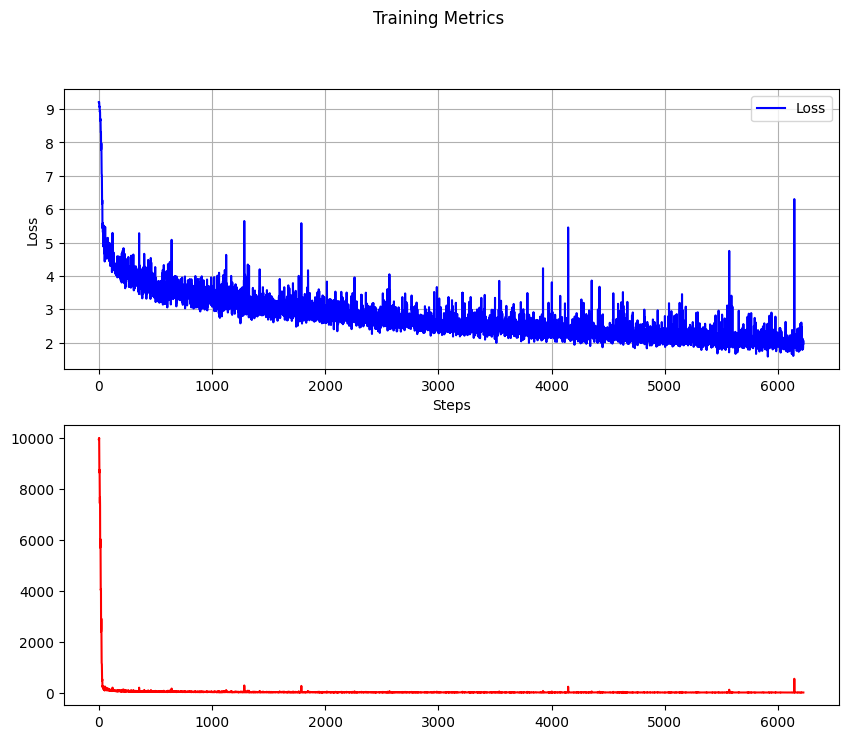

In [27]:
import torch.utils.data as data
import numpy as np
import os
import sys

import matplotlib.pyplot as plt
# Lists to store metrics for plotting
losses = []
perplexities = []
steps = []


# Make sure the models directory exists
os.makedirs("./models", exist_ok=True)

# Open the training log file
f = open(log_file, 'w')

# Create a figure for real-time plotting
plt.ion()  # Enable interactive mode
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
fig.suptitle('Training Metrics')

# Initialize empty lines for the plots
line1, = ax1.plot([], [], 'b-', label='Loss')
line2, = ax2.plot([], [], 'r-', label='Perplexity')
# Configure the axes
ax1.set_ylabel('Loss')
ax1.set_xlabel('Steps')
ax1.grid(True)
ax1.legend()
# Enable interactive mode
plt.ion()

accumulation_steps = 4
optimizer.zero_grad()

for epoch in range(1, num_epochs+1):

    data_iter = iter(data_loader)  # persistent iterator

    for i_step in range(1, total_step+1):

        # Randomly sample a caption length, and sample indices with that length
        indices = data_loader.dataset.get_train_indices()
        new_sampler = data.sampler.SubsetRandomSampler(indices=indices)
        data_loader.batch_sampler.sampler = new_sampler

        # get next batch
        try:
            images, captions = next(data_iter)
        except StopIteration:
            data_iter = iter(data_loader)
            images, captions = next(data_iter)

        images = images.to(device)
        captions = captions.to(device)

        # forward pass
        features = encoder(images)
        outputs = decoder(features, captions)

        loss = criterion(outputs.view(-1, vocab_size), captions.view(-1))
        loss = loss / accumulation_steps

        loss.backward()

        if i_step % accumulation_steps == 0 or i_step == total_step:
            optimizer.step()
            optimizer.zero_grad()

        # training stats
        running_loss = loss.item() * accumulation_steps
        perplexity = np.exp(running_loss)

        # Store metrics for plotting
        losses.append(running_loss)
        perplexities.append(perplexity)
        steps.append(i_step + (epoch-1)*total_step)

        stats = f"Epoch [{epoch}/{num_epochs}], Step [{i_step}/{total_step}], Loss: {running_loss:.4f}, Perplexity: {perplexity:.4f}"

        # print to console
        print('\r' + stats, end="")
        sys.stdout.flush()

        # log to file
        f.write(stats + '\n')
        f.flush()

        # every print_every
        if i_step % print_every == 0:
            print('\r' + stats)
            # Update plots
            # Update the data
            line1.set_data(steps, losses)
            line2.set_data(steps, perplexities)

            # Adjust the plot limits
            ax1.relim()
            ax1.autoscale_view()
            ax2.relim()
            ax2.autoscale_view()

            # Update the display
            fig.canvas.draw()
            fig.canvas.flush_events()



    # Save model
    if epoch % save_every == 0:
        torch.save(decoder.state_dict(), os.path.join('./models', f'decoder-{epoch}.pkl'))
        torch.save(encoder.state_dict(), os.path.join('./models', f'encoder-{epoch}.pkl'))

# Close log
f.close()


# Save final plot
plt.ioff()
plt.show()
# Save plots to files
fig.savefig('training_metrics.png')


2. **Loss**: `3.5626`
   - A loss of 3.5626 is fairly high, but not unusual for image captioning tasks
   - For context, in image captioning:
     - Starting loss is typically around 5-7
     - Good models often converge to loss values between 2-3
     - Excellent models might achieve losses below 2

3. **Perplexity**: `35.25523`
   - Perplexity is exp(loss), which is why it's 35.25523 = e^3.5626
   - In language modeling/captioning:
     - Lower perplexity is better
     - A perplexity of 35.25 means the model is uncertain between about 35 different words on average when making predictions
     - For image captioning:
       - Starting perplexity might be 100+
       - Good models often achieve perplexity between 10-30
       - Excellent models might get below 10

2. Maybe:
   - more epochs (maybe 5-10)
   - Adjusting the learning rate (hum ...  that was in the lectures!)
   - Using learning rate scheduling
   - Implementing early stopping based on validation metrics (hum ...  that also was in the lectures!)

Would you like me to help you modify the training loop to implement any of these improvements?

<a id='step3'></a>
## Step 3: (Optional) Validate your Model

To assess potential overfitting, one approach is to assess performance on a validation set.  If you decide to do this **optional** task, you are required to first complete all of the steps in the next notebook in the sequence (**3_Inference.ipynb**); as part of that notebook, you will write and test code (specifically, the `sample` method in the `DecoderRNN` class) that uses your RNN decoder to generate captions.  That code will prove incredibly useful here. 

If you decide to validate your model, please do not edit the data loader in **data_loader.py**.  Instead, create a new file named **data_loader_val.py** containing the code for obtaining the data loader for the validation data.  You can access:
- the validation images at filepath `'data/cocoapi/images/train2014/'`, and
- the validation image caption annotation file at filepath `'/data/annotations/captions_val2014.json'`.

The suggested approach to validating your model involves creating a json file such as [this one](https://github.com/cocodataset/cocoapi/blob/master/results/captions_val2014_fakecap_results.json) containing your model's predicted captions for the validation images.  Then, you can write your own script or use one that you [find online](https://github.com/tylin/coco-caption) to calculate the BLEU score of your model.  You can read more about the BLEU score, along with other evaluation metrics (such as TEOR and Cider) in section 4.1 of [this paper](https://arxiv.org/pdf/1411.4555.pdf).  For more information about how to use the annotation file, check out the [website](http://cocodataset.org/#download) for the COCO dataset.

In [ ]:
# (Optional) TODO: Validate your model.